In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
data_path = r'C:\Users\Lenovo\Desktop\skin\skin-disease-datasaet\train_set'

# LOAD DATA

In [3]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

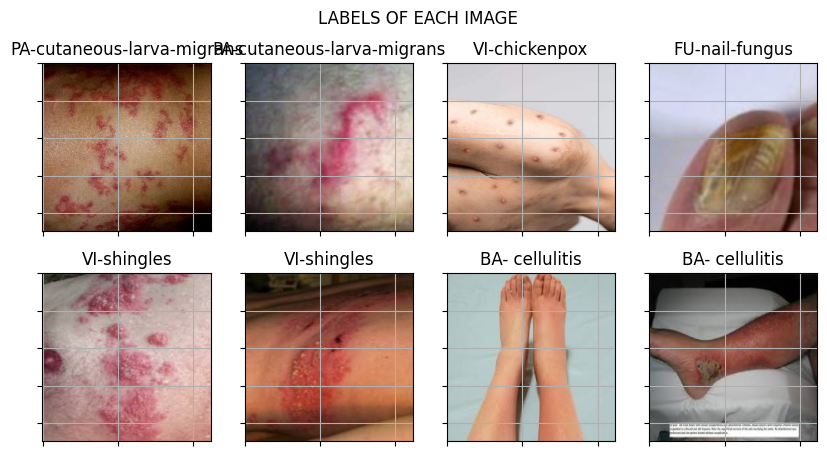

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

# PREPARE MODEL

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



94765736/94765736 [==============================] - 24s 0us/step


In [6]:
base_model.trainable = False

In [7]:
num_classes = 8
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# PREPROCESS DATA

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

# TRAIN

In [10]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/my_model.h5')

Epoch 1/12


24/24 [==============================] - 78s 3s/step - loss: 0.9045 - accuracy: 0.7263 - val_loss: 0.2055 - val_accuracy: 0.9251
Epoch 2/12
24/24 [==============================] - 78s 3s/step - loss: 0.1729 - accuracy: 0.9377 - val_loss: 0.2169 - val_accuracy: 0.9358
Epoch 3/12
24/24 [==============================] - 77s 3s/step - loss: 0.0674 - accuracy: 0.9837 - val_loss: 0.1113 - val_accuracy: 0.9679
Epoch 4/12
24/24 [==============================] - 72s 3s/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9786
Epoch 5/12
24/24 [==============================] - 71s 3s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9786
Epoch 6/12
24/24 [==============================] - 69s 3s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0684 - val_accuracy: 0.9786
Epoch 7/12
24/24 [==============================] - 69s 3s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0622 - val_accuracy: 0.9786
Epoch 8/12
24/24 [

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


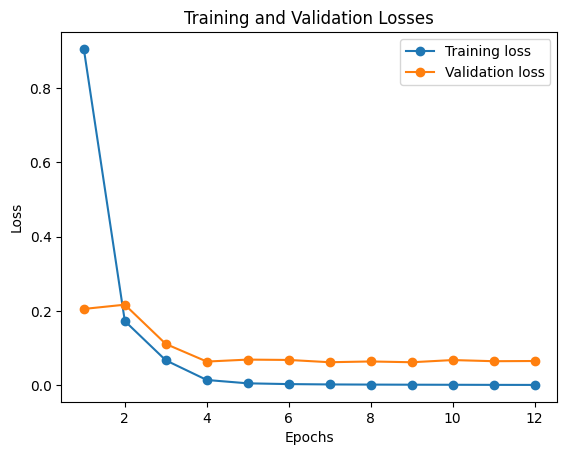

In [11]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

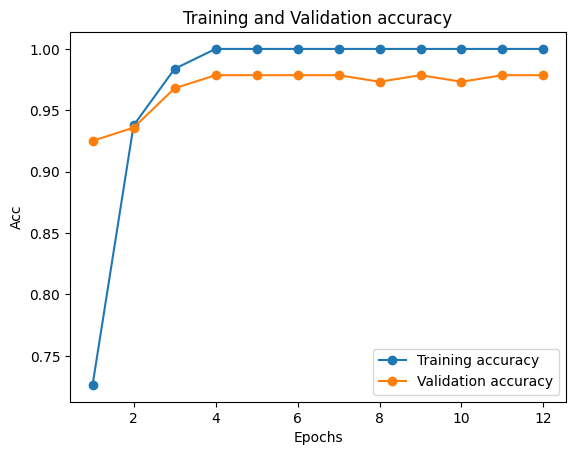

In [12]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

#  array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

#  training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# PREDICT

In [13]:
from tensorflow.keras.models import load_model

In [17]:
test_path = r'C:\Users\Lenovo\Desktop\skin\skin-disease-datasaet\test_set'

In [18]:
model = load_model('/kaggle/working/my_model.h5') 

In [19]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


1/1 [==============================] - 0s 183ms/step


In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

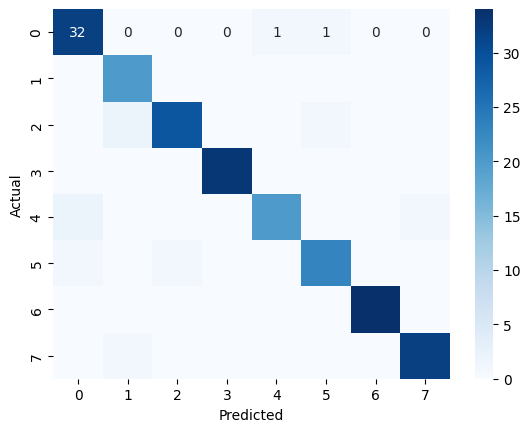

In [21]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()